<div style="background-color: #E6F3FF; padding: 15px; border-radius: 10px; text-align: center;">
    <h1 style="color: #1A5276; font-family: Arial; font-size: 28px;"><b>🚀 پیش‌بینی درآمد فیلم‌ها با استفاده از  درخت تصمیم 🎬</b></h1>
    <h3 style="color: #34495E; font-family: Arial;">تحلیل داده‌های TMDB 5000 برای پیش‌بینی موفقیت مالی فیلم‌ها</h3>
    <hr style="border: 1px solid #1A5276;">
</div>

In [2]:
import pandas as pd
import numpy as np
import json
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from collections import defaultdict
from sklearn.preprocessing import MultiLabelBinarizer

# ------------------------------------
# 1. بارگذاری داده‌ها
# ------------------------------------
movies = pd.read_csv("tmdb_5000_movies.csv")
credits = pd.read_csv("tmdb_5000_credits.csv")

# ------------------------------------
# 2. ادغام داده‌ها
# ------------------------------------
df = movies.merge(credits, on='title')

# ------------------------------------
# 3. پیش‌پردازش ویژگی‌ها
# ------------------------------------

# 🎭 ژانرها
df['genres'] = df['genres'].apply(json.loads)
df['genre_names'] = df['genres'].apply(lambda x: [genre['name'] for genre in x])
mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(mlb.fit_transform(df['genre_names']), columns=mlb.classes_, index=df.index)
df = pd.concat([df, genre_dummies], axis=1)

# 🗓️ ماه انتشار
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_month'] = df['release_date'].dt.month.fillna(0).astype(int)

# ⭐️ ستاره‌ها
df['cast'] = df['cast'].apply(json.loads)
df['main_cast'] = df['cast'].apply(lambda x: [member['name'] for member in x[:3]] if isinstance(x, list) else [])

# 🎬 کارگردان
def get_director(crew_list):
    try:
        crew = json.loads(crew_list)
        for member in crew:
            if member.get('job') == 'Director':
                return member.get('name')
    except:
        return None

df['director'] = df['crew'].apply(get_director)

# ------------------------------------
# 4. استخراج ستاره‌ها و کارگردان‌های مهم
# ------------------------------------
actor_revenue = defaultdict(list)
for _, row in df.iterrows():
    for actor in row['main_cast']:
        actor_revenue[actor].append(row['revenue'])

actor_avg_revenue = {actor: np.mean(revs) for actor, revs in actor_revenue.items()}
star_actors = set(sorted(actor_avg_revenue, key=actor_avg_revenue.get, reverse=True)[:100])

director_revenue = df.groupby('director')['revenue'].mean()
top_directors = set(director_revenue.sort_values(ascending=False).head(50).index)

# ------------------------------------
# 5. ساخت ویژگی نهایی
# ------------------------------------
def encode_features(row):
    features = {
        'budget': row['budget'],
        'popularity': row['popularity'],
        'release_month': row['release_month'],
        'has_star_1': int(row['main_cast'][0] in star_actors) if len(row['main_cast']) > 0 else 0,
        'has_star_2': int(row['main_cast'][1] in star_actors) if len(row['main_cast']) > 1 else 0,
        'has_star_3': int(row['main_cast'][2] in star_actors) if len(row['main_cast']) > 2 else 0,
        'top_director': int(row['director'] in top_directors)
    }
    for genre in mlb.classes_:
        features[genre] = 1 if genre in row['genre_names'] else 0
    return pd.Series(features)

features_df = df.apply(encode_features, axis=1)
X = features_df
y = df['revenue']

# ------------------------------------
# 6. آموزش مدل
# ------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = DecisionTreeRegressor(max_depth=10, random_state=42)
model.fit(X_train, y_train)

# ------------------------------------
# 7. تابع پیش‌بینی
# ------------------------------------
def predict_movie_revenue(budget, popularity, release_month, genres_list, cast_list, director_name,
                          model, star_actors, top_directors, genre_columns):
    features = {
        'budget': budget,
        'popularity': popularity,
        'release_month': release_month,
        'has_star_1': int(cast_list[0] in star_actors) if len(cast_list) > 0 else 0,
        'has_star_2': int(cast_list[1] in star_actors) if len(cast_list) > 1 else 0,
        'has_star_3': int(cast_list[2] in star_actors) if len(cast_list) > 2 else 0,
        'top_director': int(director_name in top_directors)
    }
    for genre in genre_columns:
        features[genre] = 1 if genre in genres_list else 0

    input_df = pd.DataFrame([features])
    return model.predict(input_df)[0]




In [3]:
# ------------------------------------
# 8. تست با یک فیلم
# ------------------------------------
pred = predict_movie_revenue(
    budget=160000000,
    popularity=150,
    release_month=7,
    genres_list=['Action', 'Science Fiction', 'Adventure'],
    cast_list=['Leonardo DiCaprio', 'Joseph Gordon-Levitt', 'Elliot Page'],
    director_name='Christopher Nolan',
    model=model,
    star_actors=star_actors,
    top_directors=top_directors,
    genre_columns=mlb.classes_
)

print(f"💰 پیش‌بینی فروش Inception: ${pred:,.0f}")

💰 پیش‌بینی فروش Inception: $653,428,261


/home/ehsanelyasi/anaconda3/envs/test1/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


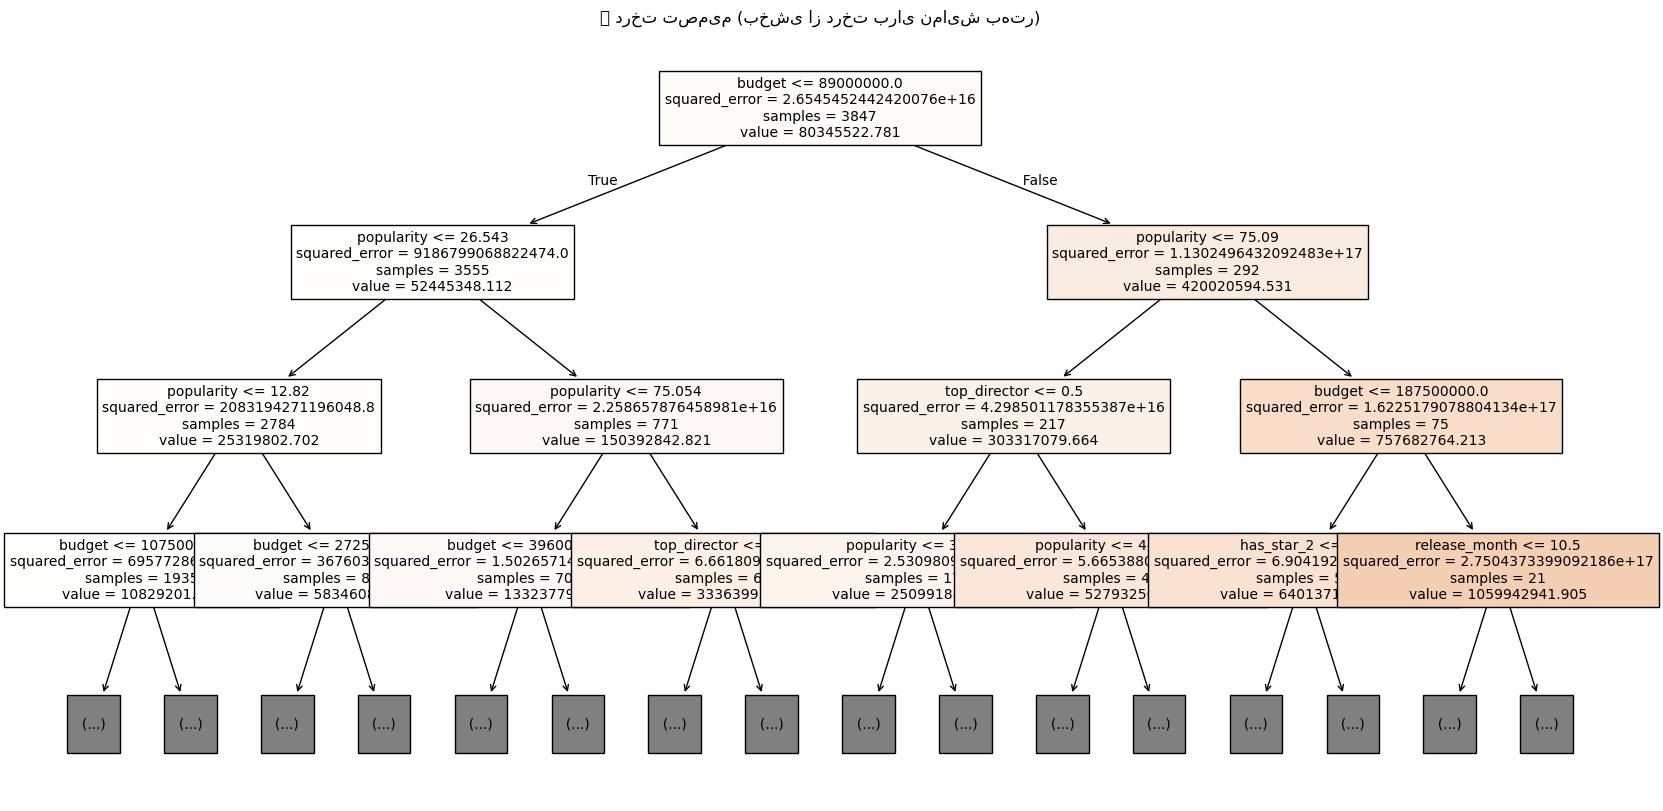

In [6]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X.columns, filled=True, fontsize=10, max_depth=3)
plt.title("📌 درخت تصمیم (بخشی از درخت برای نمایش بهتر)")
plt.show()


/tmp/ipykernel_16106/639998488.py:8: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ehsanelyasi/anaconda3/envs/test1/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


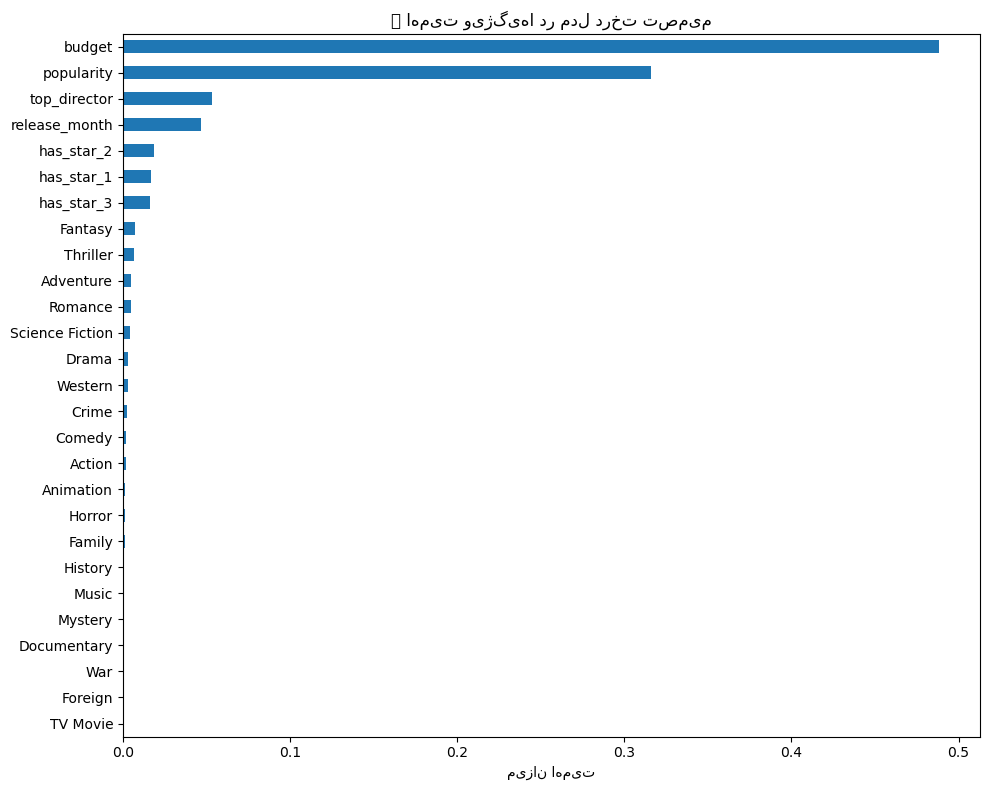

In [7]:
importances = model.feature_importances_
feat_importance = pd.Series(importances, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(10, 8))
feat_importance.plot(kind='barh')
plt.title("📊 اهمیت ویژگی‌ها در مدل درخت تصمیم")
plt.xlabel("میزان اهمیت")
plt.tight_layout()
plt.show()


/tmp/ipykernel_16106/1161702809.py:9: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ehsanelyasi/anaconda3/envs/test1/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


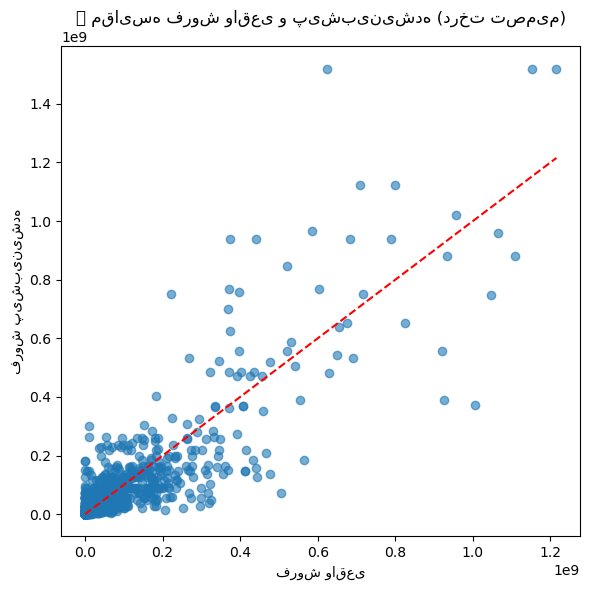

In [8]:
y_pred = model.predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("فروش واقعی")
plt.ylabel("فروش پیش‌بینی‌شده")
plt.title("🎯 مقایسه فروش واقعی و پیش‌بینی‌شده (درخت تصمیم)")
plt.tight_layout()
plt.show()


/tmp/ipykernel_16106/1854049885.py:7: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ehsanelyasi/anaconda3/envs/test1/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


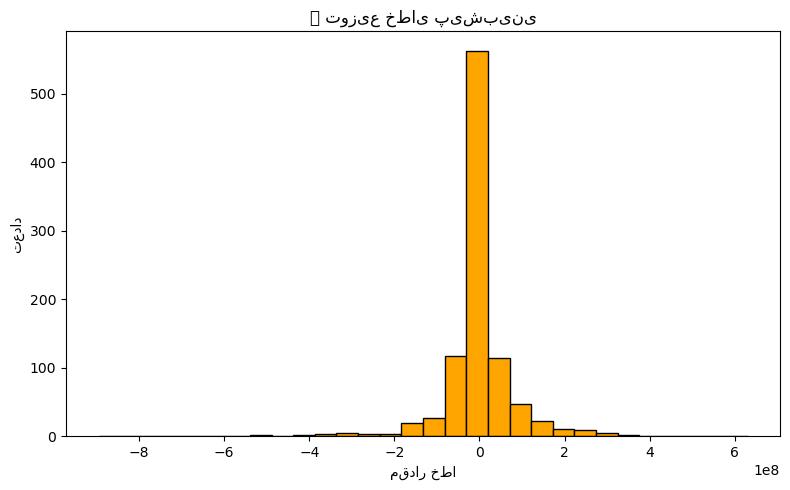

In [9]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, color='orange', edgecolor='black')
plt.title("📉 توزیع خطای پیش‌بینی")
plt.xlabel("مقدار خطا")
plt.ylabel("تعداد")
plt.tight_layout()
plt.show()
